### How Much Does a Dollar Really Cost: Economic Factors as Effective Predictors of Suicide Rates
by Nicholas Joseph Dougherty

### Project Description
This Jupyter Notebook guides through an analysis of databases from the World Health Organization's (WHO) Global Health Observatory (GHO) and the Groningen Growth and Development Centre's (GGDC) Penn World Table (PWT). The former records the suicide mortality rate (per 100,000 population) and the latter captures relative levels of income, output, input and productivity. The two databases were merged into a single pandas DataFrame, indexed by year. 

#### Executive Summary 
The GHO and PWT aggregated Pandas DataFrame revealed that, after using Recursive Feature Elimination, the 8 PWT elements which were fed into several regression models, culminated in second-degree Polynomial Regression yielding a Root Mean Square Error of .48 and an explained variance of 99%. Assuming this was done correctly the features ['ctfp', 'cwtfp', 'rwtfpna', 'labsh', 'pl_con', 'pl_gdpo', 'pl_c', 'pl_g'] (see data dictionary) can be used to very accurately estimate a country's suicide rate. This goes to show that although suicide is a very delicate and difficult subject, with many elements that exist far outside the consideration of global economics, the state of a country's monetary affairs can be used to estimate the suicide rates within a country; this is aided by how suicide rates have been relatively stable across time. 

##### Project Overview

* The DS pipeline's first-half--acquisition, preparation, and exploratory data analysis--were automated via Python scripts, the most important functions transferred to wrangle.py.
* 18 countries were initially selected for this study
    - Belarus, Bhutan, Canada, China, Czech Republic, Finland, France, Germany, Guyana
    - India, Japan, Kazakhstan, (Republic of (South)) Korea, Lithuania, Poland
    - Singapore, United States, Ukraine
        - Due to the presence of nulls in Belarus, Butan, and Guyana these countries were removed
* Nulls were handled initially based on their proportion in the dataframe. 
    - 'cor_exp', and 'stat_cap' were dropped manually due to there being no method of imputation
        - 'avh' was filled based on the mean, but this column was lated dropped due to low correlation with the target. 
* Speaking of which, the target is the age-standardized suicide rate for both sexes. 
* Exploration was conducted under the assumption that Purchasing Power Parity (PPP) would be the fairest way to compared rates across countries. The first goal of exploration, due to the presence of so many variables, was to see whether or not multi-collinearity was at play.
    - By viewing a Pearson's R correlation heatmap, it was determined that several features would be dropped due to their near perfect (.95 or greater) correlation with CGDPe. This same approach was used to exclude features that had a correlation less than .37 with the target, both_sexes. 
* Subsequent statistical analyses subjectively rejected the following null hypotheses:
    1. There is no linear relationship between the suicide rate of both sexes and CGDPe
    2. There is no linear relationship between the suicide rate an Total Factor Productivity at current PPPs. (additionally checked the welfare-relevant cwtfp)
* Statistical tests also rejected the nulls involving countries where suicide rate was larger. These nulls were rejected, showing uniformity among countries
    3. The Mean Suicide Rate in South Korea is equivalent to the Mean Suicide Rate of all countries in the dataframe. 
    4. The Mean Suicide Rate in Lithuania is equivalent to the Mean Suicide Rate of all countries in the dataframe. 
    5. 3. The Mean Suicide Rate in Kazakhstan is equivalent to the Mean Suicide Rate of all countries in the dataframe. 
* Correlation tests were conducted on each and every PWT variable, all rejected their respective nulls. In the interest of saving space, the visualizations for this will be only shown for those that were included in the feature mask via Recursive Feature Elimination RFE.
* Scaling preceded RFE. The target was not scaled, all else was adjusted by a MinMaxScaler. 
* Since the target variable and all the selected features were continuous values, regression machine learning was selected for modeling. The following models were used in the modeling notebook:
    - 1. OLS Regression
    - 2. Lasso + Lars
    - 3. Tweedie Regressor 
    - 4. Polynomial Regression
* Second Degree Polynomial Regression was the highest performer and was fit upon the test set. 
    - The test set predicted with a very good RMSE of .48 and explained variance at 99%.
****
****

### Imports, Acquisition, and Preparation

In [1]:
# standards and customs
import pandas as pd
import numpy as np
import describe as tatl
import wrangle as get
import model as mod
from collections import Counter
# plotting and stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# feature selection, splitting, scaling
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# import evaluation metrics and modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

### Acquire
- The GGDC PTW [database](https://www.rug.nl/ggdc/productivity/pwt/?lang=en).
    - *Follow the link, click Excel, import to GoogleSheets, and export as CSV*.  
        - Attribution: Feenstra, Robert C., Robert Inklaar and Marcel P. Timmer (2015), "The Next Generation of the Penn World Table" American Economic Review, 105(10), 3150-3182, available for download at www.ggdc.net/pwt
- The WHO GHO [database](https://www.rug.nl/ggdc/productivity/pwt/?lang=en).
    - *Follow the link, download data as csv* 
        - Attribution: World Health Organization. 2019. Global Health Observatory Country Views. 
    
To avoid the rigors of creating this dataframe yourself by merging them, clone my combined dataframe [here](https://github.com/nicholas-dougherty/suicide-studies/blob/main/combined.csv).         

##### The rationale for country selection
- The United States as of 2020 ranks 28th in highest suicide rates in the world. 
- I sought to obtain countries in equal number from Europe, Asia, and the Americas, with half ranking above and the other half ranking below. Originally I hoped to include Hong Kong and Taiwan, but since the former is a semi-autonomous region and the latter is still highly disputed in terms of its international role as a polity, I could not retrieve the information needed from both datasets. So I settled for China. Reliable data for South America is in scarce supply and only Cuba was usable, so the Americas only comprise Canada, United States, and Cuba in this dataframe. 
    - The included countries which rank higher than US in this unfortunate dimension of suicide are: Greenland(1), South Korea(3), Kazakhstan(5), Ukraine(11), Japan(17), France(24), Finland(26)
    - Those than rank lower are: Poland(29), Czech Republic(32), Cuba(33), Germany(33), Canada(43), (India(49), Singapore(51), China(54)

So after acquiring the data via pd.read_csv(), I first set to capture those countries by first including them in a list, named as a variable target_countries.     
Then I did the following
```
check = df.where(df['country'].isin(target_countries))
# Following that with
countries = check.dropna(subset=['country'])
# which removed all rows where the countries did not fit my criteria.
``` 
This same approach was applied to both datasets, and the same methodology was also used to eliminate years before 2000. The most reliable information comes from the 21st century as far as these datasets are concerned, and as such the temporal domain for this project is from 2000-2019.     

There were conflicts with country name which would have made joining them impossible, as such the names were replaced this way: 
```
# first eliminate the first row which has inappropriate columns, the second row are 
# the actual columns. This slice the dataframe with everything after row 1
dfnew1 = dfnew.iloc[1: , :']
# then melt and rename columns
dfnew1 = pd.melt(dfnew1, id_vars=['country', 'sex'])
# rename columns
dfnew1.columns=('country', 'sex', 'year', 'suicide_rate')

# Change conflicting country names - simple regex
dfnew1["country"] = dfnew1["country"].replace("United States of America", "United States", regex=True)
dfnew1["country"] = dfnew1["country"].replace("Czechia", "Czech Republic", regex=True)
# check value counts to ensure equal representation of each
dfnew1.country.value_counts()
```
Following this I needed to make a few more changes to the GHO suicide data before it would be fully compatible with PWT. This was the most complicated part and involved unstacking the dataframe.
```
dfnew1 = dfnew2.set_index(['sex', 'country',\ 'year']).suicide_rate.unstack(0).reset_index()
# then save to a .csv for a fresh read
dfnew1.to_csv('whocleanest.csv', index=False)
```
At last they were compatible and could be merged, left-joined on country and year. I then took the merge and saved it as its own csv which is again [this one](https://github.com/nicholas-dougherty/suicide-studies/blob/main/combined.csv).

With Acquisition complete, it was time to enter Preparation. 
***
***

### Prepare
My User-Defined Function [describe_data()](https://github.com/nicholas-dougherty/suicide-studies/blob/main/describe.py) runs the gamut of describing the initial dataframe. It revealed that 6% of my data frame had missing values. The UDF [data_prep(df)](https://github.com/nicholas-dougherty/suicide-studies/blob/main/prepare.py) deleted the two columns which had more than half their values missing across columns and rows.       

Given the nature of this information, and the high variability of this PWT's numbers, imputation could not be achieved across multiple columns, and there were only three countries responsible for the nulls. So I dropped them from the dataframe, as mentioned earlier.

```
# Lambda function returns all countries that are not equal to the unwanted three
df = df[df['country'].apply(lambda val: all(val != s for s in ['Belarus', 'Bhutan', 'Guyana']))]
```
The only column still in need of having missing values addressed was the average workhours, which was handled by the mean after using seaborns distplots to observed the impact left by it, vs. mode or median. The only countries missing this value were Ukraine and Kazakhstan

```
# fill nas with mean
df['avh'] = df.avh.fillna(df.avh.mean())
```

There are essentially no outliers in this dataframe, so that was not an issue.     
***
Originally the dataframe treated suicide rates as a string, because the confidence interval for each was included in brackets alongside the float value. This was handled via slicing and then recasting the data-type:

```
# reassign the column where only the first five values are kept.
df['both_sexes'] = pd.DataFrame(df.both_sexes.str[0:4])
# at the time, the other suicide rates were under consideration
df = df.astype({'both_sexes': 'float64', 'female': 'float64', 'male': 'float64'})
# nevertheless, this shows how to change dtype for multiple variables
```

Additionally adjustments were made to make year into a timestamp and use it as a separate column and as the index, this can be seen in greater detail in [wrangle.py](https://github.com/nicholas-dougherty/suicide-studies/blob/main/wrangle.py). 

Onto Exploration. 
***
***
### Exploratory Data Analysis

In [2]:
df, train, validate, test = get.wrangle_df()

The dataframe was split based on its time-series index. 

```
# set parameters for a .5/.3/.2 split

train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# use variables to split into train, validation, test
train_time = df[: train_size]
validate_time = df[train_size : validate_end_index]
test_time = df[validate_end_index : ]
```
Coincidentally, there is no overlap with years.     
The train set ranges from 2000-2009, validate 2010-2015, and test 2016-2019.    
Random sampling was too risky in a case where information is gathered in accordance with year.    
There would have been an uneven distribution of countries, but with this split, each country has its rates for the years of their respective temporal domains. 

The first question for me was: 
How have suicide rates varied over time?


Text(0.5, 1.0, 'Country-based Suicide Rates: 2000-2008')

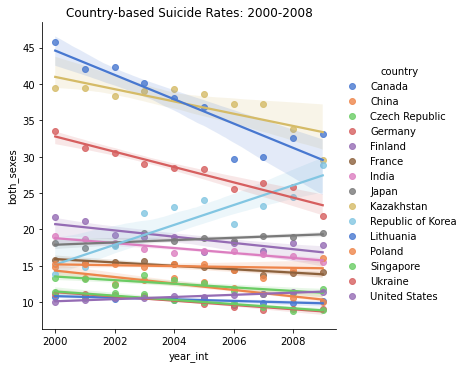

In [11]:
sns.lmplot(x='year_int', y='both_sexes', data=train, scatter=True, hue='country', palette ='muted')
ax = plt.gca()
ax.set_title('Country-based Suicide Rates: 2000-2008')


For the most part, suicide rates are relatively stable over time. All of them other than South Korea and Japan have either remained about the same or decreased. Lithuania's rate has decreased rather rapidly, and is of interest as a result. Nevertheless, to check if anything is amiss, and to consider whether or not Lithuania or South Korea could present problems for modeling later on, I sought to statistically test some null hypotheses related to each. The hopes were the fail to reject the null, in hopes that the rates wouldn't make those two countries outsiders to this dataframe. 

Does the mean suicide rate in Republic of Korea differ considerably from that of the other countries' collective mean? 

- $H0$: Mean of Suicide Rate in South Korea = Mean Suicide Rate of all countries

- $Ha$: Mean of Suicide Rate in South Korea > Mean suicide rate of all categories

In [5]:
alpha = 0.5
korea = train[train.country == 'Republic of Korea'].both_sexes
overall_mean = train.both_sexes.mean()

print(f'The mean suicide rate of all countries is: {overall_mean}')

t, p = stats.ttest_1samp(korea, overall_mean)

print(f't ~ {t:.03}, p ~ {p/2:.03}, alpha = {alpha} \n')

if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")
    
print('''
The rise in South Korea's suicide rate, and higher rate on average vary significantly from the overall rate.''') 

The mean suicide rate of all countries is: 18.288666666666668
t ~ 2.08, p ~ 0.0338, alpha = 0.5 

We reject the Null Hypothesis

The rise in South Korea's suicide rate, and higher rate on average vary significantly from the overall rate.


Does the mean suicide rate in Lithuania differ considerably from that of the other countries' collective mean? 

- $H0$: Mean of Suicide Rate in Lithuania = Mean Suicide Rate of all countries

- $Ha$: Mean of Suicide Rate in Lithuania > Mean suicide rate of all categories

In [3]:
get.test_lithuania(train)

Conducting one-sample t-test on Lithuania
The mean suicide rate of all countries is: 18.288666666666668
t ~ 10.6, p ~ 1.08e-06, alpha = 0.5 

We reject the Null Hypothesis

    So although the suicide rate in Lithuania is decreasing, 
 it is not doing so rapidly enough 
 or substantially enough to vary significantly from the overall rate.


#### I conducted Pearson R Correlation Tests on each of my continuous variables, but in the interests of space, I will show half of the variables which were selected via RFE. More on that soon, here is some sample code from the first test. 

```
# set alpha
α = .05
# conduct pearsonr test on independent and dependent variables.
r, p = stats.pearsonr(train.ctfp, train.both_sexes)

# plotting the variables used in the aforementioned test
train.plot.scatter('ctfp', 'both_sexes')
# Setting the title based on data dictionary
plt.title('Total Factor Productivity (TFP) at Current PPP: Correlation to Suicide Rate')
# displaying r at X and y positions, to the thousandths-place.
plt.text(1, 40, f'r = {r:.3f}')
# Boolean test on whether p is less than alpha. if true, the correlation is significant.
print(f' P is less than alpha: {p < α}')
```

 P is less than alpha: True


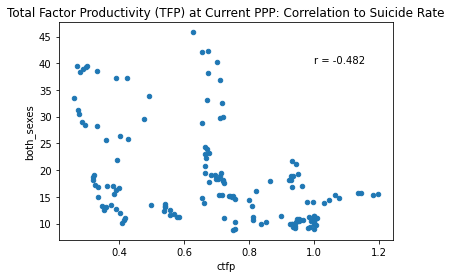


 P is less than alpha: True


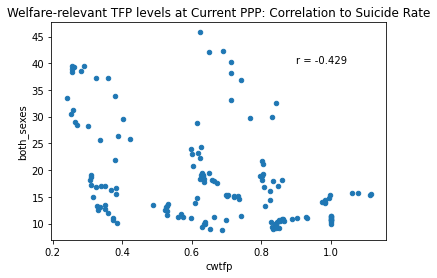


 P is less than alpha: True


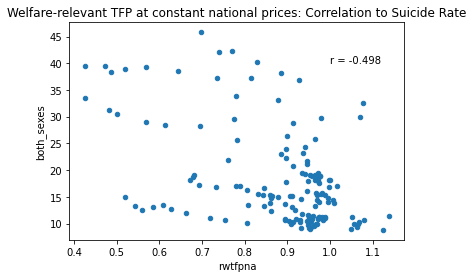


 P is less than alpha: True


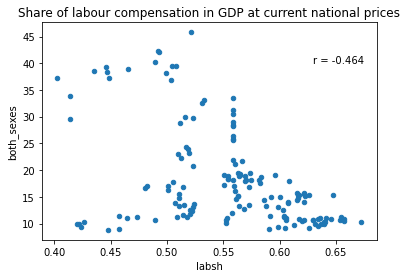

In [4]:
get.stats_visualized(train)

#### Key Takeaways from EDA

- Correlations exist between all the variables and the target, after the extraneous or unbelonging variables, along with those that violate multicollinearity, were removed from the pool after observing a heatmap in the explore.ipynb. 
- No categorical variables will be represented in the models, as there is no need for it. Additionally, since the statistical tests have shown that even the most eye-catching countries don't differ significantly in their mean from the rest of the sample, it seems as though any single one would be pointless to include. 
- The time series following the split was a convenient success, wherein there is no overlap among years. 

***
***
## Pre-processing and Modeling

In [2]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = get.wrangle_df2('both_sexes')

At this point I went in and removed the country and year_int columns, as they would not be scaled; then I scaled all of the independent features, leaving the target unscaled. A MinMaxScaler seemed to be the most reasonable scaler for this project. 

In [3]:
X_train_scaled, X_validate_scaled, X_test_scaled = get.scale_data(X_train, X_validate, X_test)

#### Establishing a Baseline
I compared the Root Mean Square Square Error (RMSE) resulting from the mean and median, and because the mean RMSE was lower by .5, I elected the y_train.mean as my baseline and put it into a dictionary like so 

In [4]:
baseline = pd.DataFrame({
        'median' : [y_train.median()] * y_train.size,
        'mean' : [y_train.mean()] * y_train.size
    })

median_rmse = mod._RMSE(y_train, baseline["median"])
mean_rmse = mod._RMSE(y_train, baseline["mean"])

print(median_rmse)
print(mean_rmse)
print('The Root Mean Squared Error of Mean is lower, indicating it will be the better baseline')

baseline_val = pd.Series([y_train.mean()] * y_validate.size)

results = {
    'baseline' : {
        'RMSE' : mean_squared_error(y_train, baseline['mean'], squared = False),
        'R^2' : r2_score(y_train, baseline['mean']),
        'RMSE_val' : mean_squared_error(y_validate, baseline_val, squared = False),
        'R^2_val' : r2_score(y_validate, baseline_val)
    }
}
results

9.556160316779955
9.076787512967103
The Root Mean Squared Error of Mean is lower, indicating it will be the better baseline


{'baseline': {'RMSE': 9.076787512967103,
  'R^2': 0.0,
  'RMSE_val': 7.226867022642867,
  'R^2_val': -0.15322056907666481}}

### Feature-Selection using Recursive Feature Elimination (RFE)

In the modeling notebook, I also checked SelectKBest, and about half the variables were in common with one another, however RFE is more accurate, as it recursively removes attributes and then builds a model on the remaining attributes. The RFE method takes the machine learning algorithm to be used and the number of required features as input. It returns the ranking of all the variables, 1 being most important, along with its support: a list of boolean values, True indicating relevant features and False indicating irrelevant features. 

Each of the eight features I selected had a rank of 1, and some of the features I ignored still ranked between 3-5. 

In [5]:
feature_mask, rankings, X_rfe = get.select_rfe(X_train_scaled, y_train, 8, return_rankings=True)

In [6]:
print(feature_mask)
print(rankings)

['ctfp', 'cwtfp', 'rwtfpna', 'labsh', 'pl_con', 'pl_gdpo', 'pl_c', 'pl_g']
cgdpe       7
ctfp        1
cwtfp       1
rtfpna      3
rwtfpna     1
labsh       1
irr         9
delta       2
pl_con      1
pl_da       8
pl_gdpo     1
csh_c      10
csh_i       5
csh_g      12
csh_r       4
pl_c        1
pl_g        1
pl_x       11
pl_k        6
dtype: int64


array([[<AxesSubplot:title={'center':'both_sexes'}>]], dtype=object)

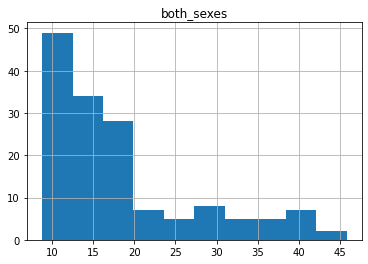

In [12]:
# With all this prepared, knowing the distribution before modeling helps guide parameters
y_train.hist()

The suicide rate of both sexes' distribution is somewhat poisson; it bears semblance to log normal and gamma distributions as well. It it positively-skewed, with most suicide rates being lower than 20 per 100,000. 

In [8]:
# Returns a dictionary of all the models used in modeling, and their RMSE and explained variance
results = get.all_models()
# displays this dictionary as a transcribed DataFrame
pd.DataFrame(results).T

,RMSE,R^2,RMSE_val,R^2_val
baseline,9.076788,0.000000,7.226867,-0.153221
linear_regression,5.160011,0.676826,4.709375,0.510290
linear_regression_OLS,5.160011,0.676826,4.709375,0.510290
polynomial_regression,2.299627,0.935812,9.803503,-1.122144
polynomial_regression_interactions_only,2.659142,0.914174,9.525112,-1.003330
tweedie_regressor_poisson,4.928235,0.705206,4.679829,0.516416
tweedie_regressor_compound_poisson_gamma,5.005426,0.695899,4.701445,0.511938


R-Squared is the ratio of the Explained Sum of Squares (ESS) to the Total Sum of Squares (TSS). It is the explained variance by its very definition. Explained variance is used to measure the discrepancy between a model and actual data. In other words, it’s the part of the model’s total variance that is explained by factors that are actually present and isn’t due to error variance.

Higher percentages of explained variance indicates a stronger strength of association. And that means its strengthens the validity and precision of your predictions. The explained variance of the train set for second-degree polynomial regression is the strongest, and was used to fit it upon test. 

In [12]:
# Fit best performing model on test 

# Polynomial Regression. Degreee of 2, without bias or interaction only
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
# fit to test
poly.fit(X_test[feature_mask])

# Undergo transformation
X_test_poly = pd.DataFrame(
    poly.transform(X_test[feature_mask]),
    columns = poly.get_feature_names(X_test[feature_mask].columns),
    index = X_test[feature_mask].index
)

# set transofrmation as fit via linearregression
model = LinearRegression()
model.fit(X_test_poly, y_test)

# retrieve explained variance score 
r2_score(y_test, model.predict(X_test_poly))

# add to results
results['TEST_polynomial_regression'] = {
    'RMSE' : mean_squared_error(y_test, model.predict(X_test_poly), squared = False),
    'R^2' : r2_score(y_test, model.predict(X_test_poly))
}

In [13]:

pd.DataFrame(results).T

,RMSE,R^2,RMSE_val,R^2_val
baseline,9.076788,0.000000,7.226867,-0.153221
linear_regression,5.160011,0.676826,4.709375,0.510290
linear_regression_OLS,5.160011,0.676826,4.709375,0.510290
polynomial_regression,2.299627,0.935812,9.803503,-1.122144
polynomial_regression_interactions_only,2.659142,0.914174,9.525112,-1.003330
tweedie_regressor_poisson,4.928235,0.705206,4.679829,0.516416
tweedie_regressor_compound_poisson_gamma,5.005426,0.695899,4.701445,0.511938
TEST_polynomial_regression,0.475029,0.990201,NaN,NaN


*** 
*** 
## Conclusion



This research’s principle aim now is to generate a plan of action that will facilitate effective measurement of the relationships between the economic factors which may overtly lead to the Durkheimian models of isolation and despondency that blend into suicidality.       

RFE in conjunction with the results of machine learning insinuate that Total Factor Productivity (TFP)-level at current Purchasing Power Parities (PPP) __ctfp__, Welfare-relevant TFP levels at current PPPs __cwtfp__, Welfare-relevant TFP at Constant National Prices (CNP) __rwtfpna__, Share of labour compensation in Gross Domestic Product (GDP) at CNP __labsh__, Price level of Real consumption of households and governments(CCON) __pl_con__, Price-level of Output-side real GDP at current PPPs __pl_gdpo__, Price-level of household consumption __pl_c__, and price-level of government consumption __pl_g__ are collectively valuable estimators of suicide rates.
This goes to show that although suicide is a very delicate and difficult subject, with many elements that exist far outside the consideration of global economics, the state of a country's monetary affairs can be used to estimate the suicide rates within a country; this is aided by how suicide rates have been relatively stable across time. 

#### Actionable recommendations: 
WHO publishes suicide rates every two-to-three years. Once the PWT and GHO data concerning the impact of COVID is present in both datasets, aggregate this data as well. 
Because suicide rates have been relatively stable across time, the train, validate, test splits should not be too severely impacted, even with the anticipated changes of the upcoming data deluge. It is perhaps still wisest to index based on the years, so that each country's data is represented in totality. 
To further test the limits of these models, more country's can be included, but certain categories may be lost. However, if these eight features at the very least are fully filled-out, then I have high hopes that a model will perform well. 

Although time-series analysis was not performed in any meaningful way here, the index does suit it, and would be worth further investigation. 